# MIDI Score Evaluation Using MGEval - Python3 Part

## Setup
1. Set up a Python 3 environment:
```sh
conda create -n mgeval_py3 python=3
conda activate mgeval_py3
```
2. Install dependencies from PyPI:
```sh
pip install numpy scipy scikit-learn pretty-midi notebook
```

## Features
Features that can only be extracted using Python 3:
- `total_used_pitch`
- `total_pitch_class_histogram`
- `bar_pitch_class_histogram`
- `pitch_class_transition_matrix`
- `pitch_range`
- `avg_IOI`

We use *auto-reload* to automatically reload the Python script without restarting the Jupyter kernel.

In [1]:
%load_ext autoreload
%autoreload 2

We will be using `core3` module, which is a modified version of `core` module without features relying on `python-midi`'s MIDI parsing and with some compatibility fix for Python 3.

In [2]:
import glob

# import midi
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
import seaborn as sns

from mgeval import core3, utils

In [3]:
jazz_train_set = glob.glob('/Users/roseqsun/Desktop/InterpretableObjectiveEvaluation/wjazzd/*.mid')
jazz_gen_set = glob.glob('/Users/roseqsun/Desktop/InterpretableObjectiveEvaluation/out_0405/*.mid')

In [4]:
num_samples = 126

## Absolute measurement: statistic analysis

Compared to the Python 2 version, the Python 3 version has one important change:
We need to explicitly convert `jazz_train_set_eval.keys()` into a list. In Python 3, calling `keys()` method only returns a view object.

Also, we need to use `core3` instead.

`total_used_pitch` function does not have `num_tracks` argument.

In [43]:
jazz_train_set_eval = {'total_used_pitch': np.zeros((num_samples, 1))}
metrics_list = list(jazz_train_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_train_set[i])
    jazz_train_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)

In [44]:
jazz_train_set_eval

{'total_used_pitch': array([[17.],
        [25.],
        [42.],
        [17.],
        [26.],
        [27.],
        [29.],
        [24.],
        [17.],
        [23.],
        [30.],
        [21.],
        [28.],
        [29.],
        [33.],
        [24.],
        [25.],
        [25.],
        [24.],
        [40.],
        [34.],
        [35.],
        [29.],
        [28.],
        [30.],
        [36.],
        [21.],
        [29.],
        [26.],
        [37.],
        [30.],
        [17.],
        [30.],
        [30.],
        [22.],
        [32.],
        [30.],
        [35.],
        [27.],
        [25.],
        [21.],
        [30.],
        [28.],
        [32.],
        [16.],
        [38.],
        [26.],
        [30.],
        [28.],
        [27.],
        [32.],
        [24.],
        [25.],
        [24.],
        [22.],
        [34.],
        [18.],
        [30.],
        [22.],
        [25.],
        [38.],
        [26.],
        [38.],
        [21.],
        [28.],
     

In [45]:
jazz_gen_set_eval = {'total_used_pitch': np.zeros((num_samples, 1))}
metrics_list = list(jazz_gen_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_gen_set[i])
    jazz_gen_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)

In [46]:
jazz_gen_set_eval

{'total_used_pitch': array([[23.],
        [21.],
        [21.],
        [33.],
        [22.],
        [28.],
        [25.],
        [33.],
        [20.],
        [23.],
        [40.],
        [27.],
        [20.],
        [30.],
        [25.],
        [30.],
        [23.],
        [22.],
        [22.],
        [32.],
        [28.],
        [22.],
        [17.],
        [27.],
        [35.],
        [39.],
        [43.],
        [29.],
        [23.],
        [24.],
        [37.],
        [37.],
        [25.],
        [42.],
        [36.],
        [32.],
        [30.],
        [16.],
        [19.],
        [25.],
        [40.],
        [24.],
        [22.],
        [32.],
        [33.],
        [17.],
        [28.],
        [24.],
        [34.],
        [19.],
        [30.],
        [25.],
        [34.],
        [19.],
        [26.],
        [29.],
        [31.],
        [18.],
        [31.],
        [24.],
        [34.],
        [23.],
        [23.],
        [26.],
        [29.],
     

In [47]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_train_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_train_set_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_gen_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_gen_set_eval[metrics_list[i]], axis=0))

total_used_pitch:
------------------------
 demo_set
  mean:  [27.34126984]
  std:  [5.9310358]
------------------------
 demo_set
  mean:  [26.8968254]
  std:  [6.27394381]


## Relative measurement: generalizes the result among features with various dimensions

In [48]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
jazz_train_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
jazz_gen_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        jazz_train_set_intra[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_train_set_eval[metrics_list[i]][train_index])
        jazz_gen_set_intra[test_index[0]][i] = utils.c_dist(jazz_gen_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]][train_index])


In [49]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]])

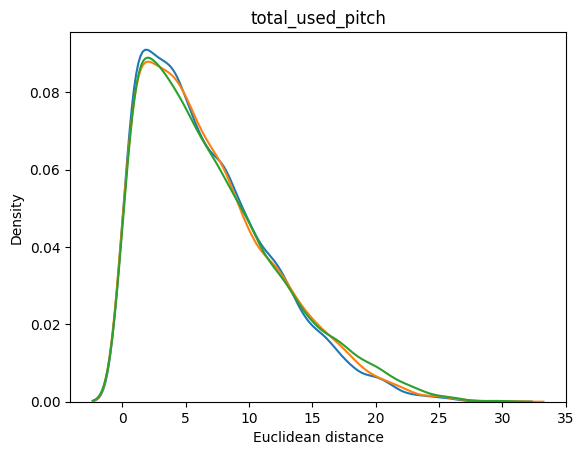

In [50]:
plot_jazz_train_set_intra = np.transpose(jazz_train_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_jazz_gen_set_intra = np.transpose(jazz_gen_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_jazz_train_set_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_jazz_gen_set_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

In [51]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))

    print(' comp_set1_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))

total_used_pitch:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.0005583858197179314
  Overlap area: 0.9512011885027746
 demo_set2
  Kullback–Leibler divergence: 0.005951475044465509


/Users/roseqsun/Desktop/mgeval_rose/mgeval/mgeval/utils.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


  Overlap area: 0.9520036411793805
 comp_set1_set2
  Kullback–Leibler divergence: 0.004532043405621567
  Overlap area: 0.9445972206600862


In [39]:
jazz_train_set_eval = {'total_pitch_class_histogram': np.zeros((num_samples, 12))}
metrics_list = list(jazz_train_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_train_set[i])
    jazz_train_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)
    
jazz_gen_set_eval = {'total_pitch_class_histogram': np.zeros((num_samples, 12))}
metrics_list = list(jazz_gen_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_gen_set[i])
    jazz_gen_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)

In [40]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_train_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_train_set_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_gen_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_gen_set_eval[metrics_list[i]], axis=0))

total_pitch_class_histogram:
------------------------
 demo_set
  mean:  [0.10907668 0.06154909 0.09585462 0.09327083 0.06338785 0.11403615
 0.04623969 0.10589697 0.07492631 0.08237153 0.10678002 0.04661026]
  std:  [0.0496682  0.04130235 0.0656734  0.05922012 0.04111386 0.04903865
 0.03298873 0.05422112 0.04933339 0.05198173 0.05368737 0.03237482]
------------------------
 demo_set
  mean:  [0.08755671 0.07434587 0.07694625 0.08751093 0.08194301 0.0882872
 0.0843154  0.08767182 0.07866705 0.07602806 0.09684801 0.0798797 ]
  std:  [0.05460818 0.04615099 0.04755871 0.0755124  0.05303875 0.05241065
 0.06936155 0.05257176 0.04980662 0.04482538 0.07777043 0.04606955]


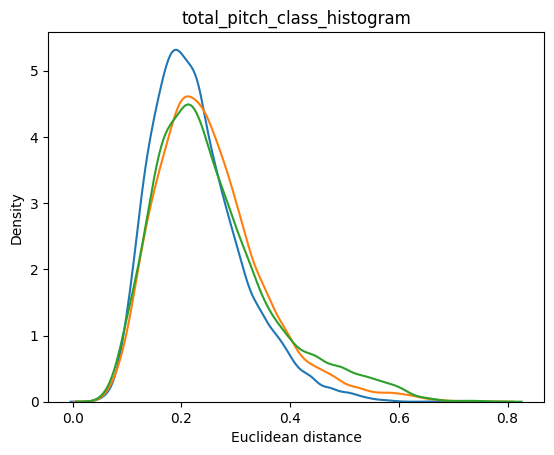

In [41]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
jazz_train_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
jazz_gen_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        jazz_train_set_intra[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_train_set_eval[metrics_list[i]][train_index])
        jazz_gen_set_intra[test_index[0]][i] = utils.c_dist(jazz_gen_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]][train_index])

loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]])

plot_jazz_train_set_intra = np.transpose(jazz_train_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_jazz_gen_set_intra = np.transpose(jazz_gen_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_jazz_train_set_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_jazz_gen_set_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

In [42]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))

    print(' comp_set1_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))


total_pitch_class_histogram:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.028802185316917965
  Overlap area: 0.8893069230305494
 demo_set2
  Kullback–Leibler divergence: 0.02524926680902765
  Overlap area: 0.9481443477055063
 comp_set1_set2
  Kullback–Leibler divergence: 0.07776145783236535
  Overlap area: 0.8916160875992288


In [35]:
jazz_train_set_eval = {'pitch_range': np.zeros((num_samples, 1))}
metrics_list = list(jazz_train_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_train_set[i])
    jazz_train_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)
    
jazz_gen_set_eval = {'pitch_range': np.zeros((num_samples, 1))}
metrics_list = list(jazz_gen_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_gen_set[i])
    jazz_gen_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)

In [36]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_train_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_train_set_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_gen_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_gen_set_eval[metrics_list[i]], axis=0))

pitch_range:
------------------------
 demo_set
  mean:  [28.6031746]
  std:  [6.00142756]
------------------------
 demo_set
  mean:  [28.28571429]
  std:  [6.51232914]


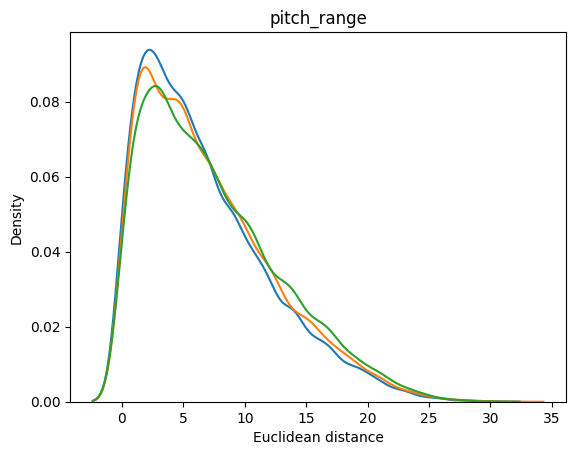

In [37]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
jazz_train_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
jazz_gen_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        jazz_train_set_intra[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_train_set_eval[metrics_list[i]][train_index])
        jazz_gen_set_intra[test_index[0]][i] = utils.c_dist(jazz_gen_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]][train_index])

loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]])

plot_jazz_train_set_intra = np.transpose(jazz_train_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_jazz_gen_set_intra = np.transpose(jazz_gen_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_jazz_train_set_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_jazz_gen_set_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

In [38]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))

    print(' comp_set1_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))

pitch_range:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.002280383939214547
  Overlap area: 0.9390217149453794
 demo_set2
  Kullback–Leibler divergence: 0.014780434567946373


/Users/roseqsun/Desktop/mgeval_rose/mgeval/mgeval/utils.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


  Overlap area: 0.9397380579536505
 comp_set1_set2
  Kullback–Leibler divergence: 0.008649614175018156
  Overlap area: 0.9131668861659444


In [28]:
jazz_train_set_eval = {'avg_IOI': np.zeros((num_samples, 1))}
metrics_list = list(jazz_train_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_train_set[i])
    jazz_train_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)
    
jazz_gen_set_eval = {'avg_IOI': np.zeros((num_samples, 1))}
metrics_list = list(jazz_gen_set_eval.keys())
for i in range(0, num_samples):
    feature = core3.extract_feature(jazz_gen_set[i])
    jazz_gen_set_eval[metrics_list[0]][i] = getattr(core3.metrics(), metrics_list[0])(feature)

In [29]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_train_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_train_set_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(jazz_gen_set_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(jazz_gen_set_eval[metrics_list[i]], axis=0))

avg_IOI:
------------------------
 demo_set
  mean:  [0.25251242]
  std:  [0.09656806]
------------------------
 demo_set
  mean:  [0.1334591]
  std:  [0.03730498]


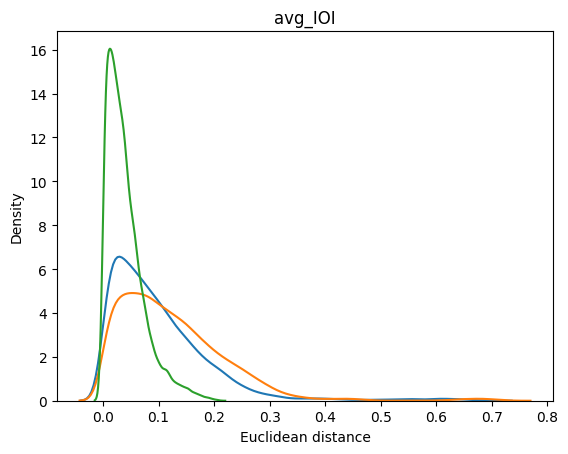

In [30]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
jazz_train_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
jazz_gen_set_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        jazz_train_set_intra[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_train_set_eval[metrics_list[i]][train_index])
        jazz_gen_set_intra[test_index[0]][i] = utils.c_dist(jazz_gen_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]][train_index])

loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(jazz_train_set_eval[metrics_list[i]][test_index], jazz_gen_set_eval[metrics_list[i]])

plot_jazz_train_set_intra = np.transpose(jazz_train_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_jazz_gen_set_intra = np.transpose(jazz_gen_set_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_jazz_train_set_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_jazz_gen_set_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

In [34]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_gen_set_intra[i], plot_sets_inter[i]))

    print(' comp_set1_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))
    print('  Overlap area:', utils.overlap_area(plot_jazz_train_set_intra[i],plot_jazz_gen_set_intra[i]))

avg_IOI:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.04502069650258146
  Overlap area: 0.8394466437807676
 demo_set2
  Kullback–Leibler divergence: 0.08395031534217429
  Overlap area: 0.47057169499896817
 comp_set1_set2
  Kullback–Leibler divergence: 0.07736313686117635
  Overlap area: 0.5741994278877087
